In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

In [2]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-11 02:21:44.257 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:65 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-11 02:21:47.718 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:69 - read train split with 60295 chip files (out of 60396)
2024-04-11 02:21:47.719 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:71 - max cache size is -1
2024-04-11 02:21:48.424 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:65 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-11 02:21:49.113 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:69 - read val split with 12288 chip files (out of 12304)
2024-04-11 02:21:49.113 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:71 - max cache size is -1
2024-04-11 02:21:49.

In [3]:
dltrain = dl.train_dataloader()

m = hydra.utils.instantiate(conf.model)

optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)

sum([np.product(p.shape) for p in m.parameters()])

570723

In [13]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o)*t + torch.log(1-o)*(1-t) + 1e-5)
    
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()


KeyboardInterrupt



Text(0, 0.5, 'loss')

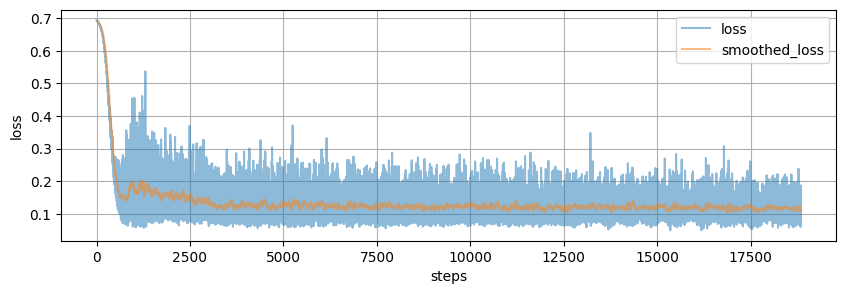

In [5]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [6]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3769 of 3769) |####################| Elapsed Time: 0:00:13 Time:  0:00:130001


((60295, 99), (60295, 99))

In [7]:
idxs = np.random.permutation(len(targets))[:300]

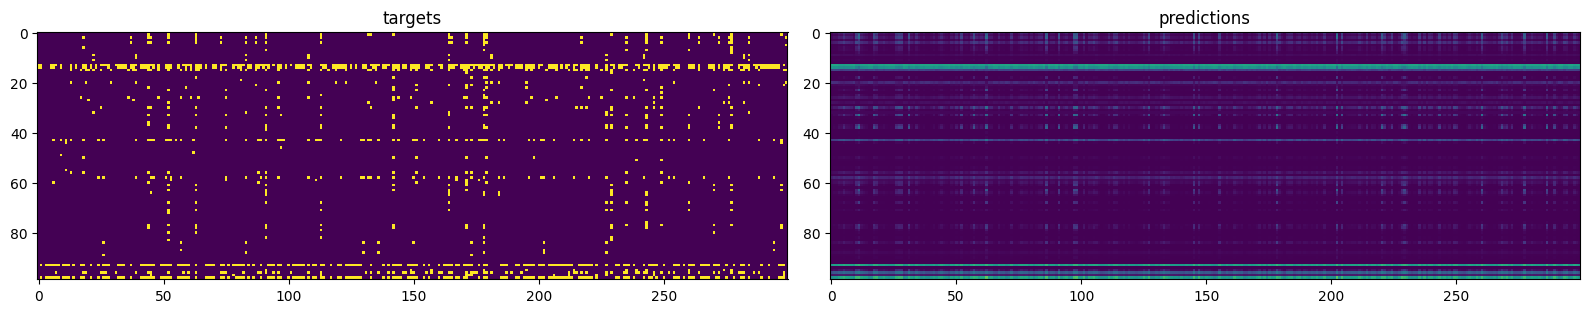

In [8]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [9]:
tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
acc = lambda y_true, y_pred: np.mean(y_true==y_pred)

metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'tnr': tnr(y_true, y_pred), 'acc': acc(y_true, y_pred)}

In [10]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.4239633365624979,
 'tnr': 0.9848111880569174,
 'acc': 0.9570726755070399}

In [11]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    

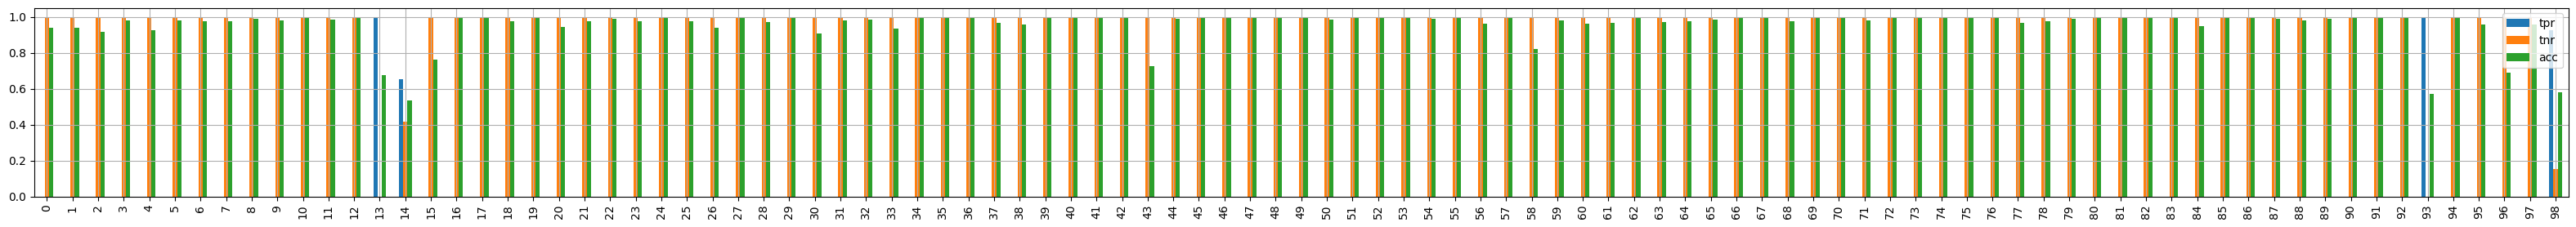

In [12]:
pd.DataFrame(r).plot(kind='bar', figsize=(40,3))
plt.grid()